In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
pd.options.display.max_columns = None
from sklearn.linear_model import LogisticRegression

In [2]:
loan = pd.read_csv('/Users/shanesquires/Downloads/lending-club-loan-data/loan.csv')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
loan = loan[['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'annual_inc',
             'issue_d', 'dti', 'revol_bal', 'total_pymnt', 'loan_status']]

In [4]:
loan['issue_d']=pd.to_datetime(loan['issue_d'])

In [5]:
loan['issue_d_year']=loan['issue_d'].dt.year

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13538d438>,
      dtype=object)

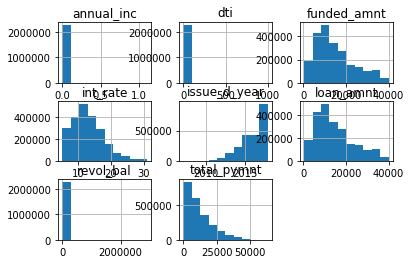

In [6]:
loan.hist()

# Part 1 

### a.)

All the numeric variables in the dataset are skewed posisitively (i.e. rightward). this is confirmed by the skewness measure below, which are all greater than zero. Three of the variables show signs of containing outliers (i.e. annual_inc, dti and revol_bal), given the skewness measures are far greater than one. The boxplots for those variables below illustrate this, as well as the high maximum values relative to the median for each shown in the descriptive statistics--e.g. the annual_inc variable is nearly 1,700 times greater than the median. 

In [7]:
loan.skew()

loan_amnt         0.777782
funded_amnt       0.778779
int_rate          0.768074
annual_inc      493.886088
dti              29.201854
revol_bal        13.231988
total_pymnt       1.275028
issue_d_year     -0.825370
dtype: float64

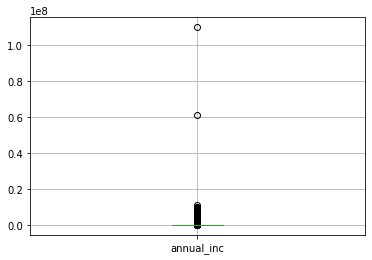

In [8]:
loan.boxplot(column='annual_inc', return_type='axes')

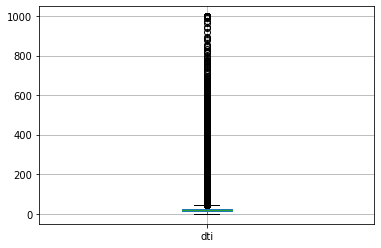

In [9]:
loan.boxplot(column='dti', return_type='axes')

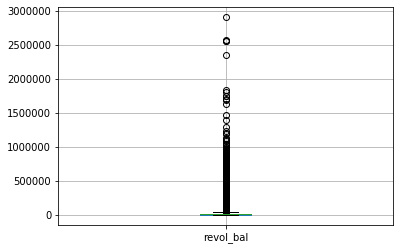

In [10]:
loan.boxplot(column='revol_bal', return_type='axes')

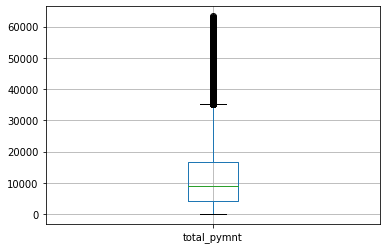

In [11]:
loan.boxplot(column='total_pymnt', return_type='axes')

In [12]:
loan.describe()

,loan_amnt,funded_amnt,int_rate,annual_inc,dti,revol_bal,total_pymnt,issue_d_year
count,2.260668e+06,2.260668e+06,2.260668e+06,2.260664e+06,2.258957e+06,2.260668e+06,2.260668e+06,2.260668e+06
mean,1.504693e+04,1.504166e+04,1.309291e+01,7.799243e+04,1.882420e+01,1.665846e+04,1.182403e+04,2.015858e+03
std,9.190245e+03,9.188413e+03,4.832114e+00,1.126962e+05,1.418333e+01,2.294831e+04,9.889599e+03,1.792634e+00
min,5.000000e+02,5.000000e+02,5.310000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,2.007000e+03
25%,8.000000e+03,8.000000e+03,9.490000e+00,4.600000e+04,1.189000e+01,5.950000e+03,4.272580e+03,2.015000e+03
50%,1.290000e+04,1.287500e+04,1.262000e+01,6.500000e+04,1.784000e+01,1.132400e+04,9.060870e+03,2.016000e+03
75%,2.000000e+04,2.000000e+04,1.599000e+01,9.300000e+04,2.449000e+01,2.024600e+04,1.670797e+04,2.017000e+03
max,4.000000e+04,4.000000e+04,3.099000e+01,1.100000e+08,9.990000e+02,2.904836e+06,6.329688e+04,2.018000e+03


### b)

The number of null values relative to the sample available is small, so removing records with a null value in any feild will be alright; filtering outliers will romove them in this case. 

In [13]:
loan.isna().sum()

loan_amnt          0
funded_amnt        0
term               0
int_rate           0
grade              0
annual_inc         4
issue_d            0
dti             1711
revol_bal          0
total_pymnt        0
loan_status        0
issue_d_year       0
dtype: int64

In [14]:
loanDtiNA =  loan[loan['dti'].isnull()]


### c) 

There doesn't seem to be much difference in the distributions of the full set and just the set of records containing a null value, increasing confidence that no information is lost.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133a4ea58>,
      dtype=object)

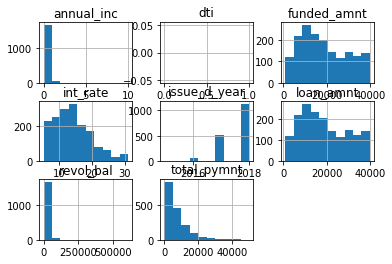

In [15]:
loanDtiNA.hist()

In [16]:
Tab = pd.crosstab(index=loan["grade"],  # Make a crosstab
                      columns="count")

In [17]:
naTab = pd.crosstab(index=loanDtiNA["grade"],  # Make a crosstab
                      columns="count") 

In [18]:
Tab/Tab.sum()

col_0,count
grade,
A,0.191548
B,0.293523
C,0.287549
D,0.143508
E,0.060000
F,0.018490
G,0.005382


In [19]:
naTab/naTab.sum()

col_0,count
grade,
A,0.168907
B,0.255406
C,0.297487
D,0.192870
E,0.059030
F,0.016365
G,0.009936


### d)

The double median absolute value is used to identify ouliers becasue the variables that we wish to scan for outliers all show evidence of asymetry.

In [20]:
def doubleMAD(y,threshold=3.5):
    med = y.median()
    absDev = (y - med).abs()
    leftMad = absDev[y <= med].median()
    rightMad = absDev[y >= med].median()
    y_mad = leftMad * np.ones(len(y))
    y_mad[y > med] = rightMad
    modifiedZScore = 0.6745 * absDev / y_mad
    modifiedZScore[y == med] = 0
    return modifiedZScore < threshold

In [21]:
mask = doubleMAD(loan['annual_inc']) & doubleMAD(loan['dti']) & loan['dti']>=0 & doubleMAD(loan['revol_bal'])

In [22]:
loanSubset = loan[mask].dropna()

### E)

Now the skewness of the problemed variables seems reasonable, there are no longer null values in the dataset and all the histograms resemble identifiable distributions!

In [23]:
loanSubset.skew()

loan_amnt         0.777912
funded_amnt       0.778909
int_rate          0.767947
annual_inc      493.966600
dti              29.201938
revol_bal        13.235079
total_pymnt       1.274564
issue_d_year     -0.824601
dtype: float64

In [24]:
loanSubset.isna().sum()

loan_amnt       0
funded_amnt     0
term            0
int_rate        0
grade           0
annual_inc      0
issue_d         0
dti             0
revol_bal       0
total_pymnt     0
loan_status     0
issue_d_year    0
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x130459e48>,
      dtype=object)

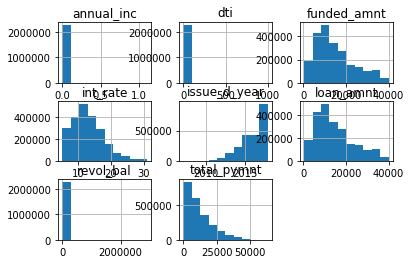

In [25]:
loanSubset.hist()

### f)

Less than 6% of the dataset has been discarded

In [26]:
loan.shape

(2260668, 12)

In [27]:
2260668/2135067-1

0.05882766208273549

#  Part 2 !  !

In [28]:
mask1 = (loanSubset['issue_d'] <= '2016-06-01') & loanSubset['term'].str.contains('36 months')

In [29]:
loanSubset1 = loanSubset[mask1]

In [30]:
Tab1 = pd.crosstab(index=loanSubset1['loan_status'],  
                      columns="count")

## 1)

About 80 percent of the loans have been fully paid. 

In [31]:
Tab1/Tab1.sum()

col_0,count
loan_status,
Charged Off,0.140403
Current,0.052439
Default,0.000005
Does not meet the credit policy. Status:Charged Off,0.000820
Does not meet the credit policy. Status:Fully Paid,0.002254
Fully Paid,0.801222
In Grace Period,0.000696
Late (16-30 days),0.000270
Late (31-120 days),0.001891


In [32]:
loanSubset1['default'] = np.where(loanSubset1['loan_status']=='Fully Paid', 0, 1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [33]:
pd.crosstab(index=loanSubset1['default'],  
                      columns="count")

col_0,count
default,
0,634405
1,157392


In [34]:
yrGrdTab = pd.crosstab(index=loanSubset1["default"], 
                             columns=[loanSubset1["grade"],
                                      loanSubset1["issue_d_year"]],
                             margins=True)

In [35]:
yrGrdTab1 = yrGrdTab/yrGrdTab.loc["All"]

## 2)

G-grade loans funded in 2007 had the highest default rate of 100%!

In [36]:
display(yrGrdTab1)

grade                A                                                  \
issue_d_year      2007      2008      2009     2010     2011      2012   
default                                                                  
0             0.756757  0.874214  0.913549  0.94663  0.93601  0.927648   
1             0.243243  0.125786  0.086451  0.05337  0.06399  0.072352   
All           1.000000  1.000000  1.000000  1.00000  1.00000  1.000000   

grade                                                        B            \
issue_d_year      2013      2014      2015      2016      2007      2008   
default                                                                    
0             0.954388  0.946169  0.945417  0.654365  0.540816  0.728956   
1             0.045612  0.053831  0.054583  0.345635  0.459184  0.271044   
All           1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

grade                                                                     \
issue_d_year      2009      2010      2011      2012      2013      2014   
default                                                                    
0             0.836678  0.865597  0.894324  0.874323  0.902141  0.892761   
1             0.163322  0.134403  0.105676  0.125677  0.097859  0.107239   
All           1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

grade                                    C                               \
issue_d_year      2015      2016      2007     2008      2009      2010   
default                                                                   
0             0.880207  0.621648  0.432624  0.62069  0.754451  0.775845   
1             0.119793  0.378352  0.567376  0.37931  0.245549  0.224155   
All           1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   

grade                                                                    \
issue_d_year      2011      2012      2013     2014      2015      2016   
default                                                                   
0             0.844757  0.824278  0.847042  0.82805  0.804844  0.569753   
1             0.155243  0.175722  0.152958  0.17195  0.195156  0.430247   
All           1.000000  1.000000  1.000000  1.00000  1.000000  1.000000   

grade                D                                                    \
issue_d_year      2007      2008      2009      2010      2011      2012   
default                                                                    
0             0.222222  0.400955  0.665851  0.705507  0.819191  0.788522   
1             0.777778  0.599045  0.334149  0.294493  0.180809  0.211478   
All           1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

grade                                                   E                      \
issue_d_year     2013      2014      2015      2016  2007      2008      2009   
default                                                                         
0             0.79607  0.778255  0.736736  0.510358  0.09  0.221053  0.600649   
1             0.20393  0.221745  0.263264  0.489642  0.91  0.778947  0.399351   
All           1.00000  1.000000  1.000000  1.000000  1.00  1.000000  1.000000   

grade                                                                     \
issue_d_year      2010      2011      2012      2013      2014      2015   
default                                                                    
0             0.651786  0.794118  0.781132  0.766945  0.729691  0.670476   
1             0.348214  0.205882  0.218868  0.233055  0.270309  0.329524   
All           1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

grade                          F                                          \
issue_d_year      2016      2007      2008      2009      2010      2011   
default                                                                    
0             0.454406  0.096154  0.099099  0.504762  0.494505  0.759259   
1             0.545594  0.903846  

In [37]:
loanSubset1['annRateRet'] = (loanSubset1['total_pymnt'] / loanSubset1['funded_amnt'])**(1/3)-1


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [38]:
loanSubset1['annRateRet'].describe()

count    791797.000000
mean          0.015565
std           0.096343
min          -1.000000
25%           0.022558
50%           0.040167
75%           0.058835
max           0.164457
Name: annRateRet, dtype: float64

In [39]:
annRetXYrGrd = loanSubset1.groupby(['grade', 'issue_d_year'])['annRateRet'].mean().reset_index()



## 3)

The mean of the mean annualized returns bucketed by year of origination and grade is roughly 60 basis points.

In [40]:
annRetXYrGrd['annRateRet'].mean()

0.005870924328318231

# Part 3)

Normalization of the input variables as well as ensuring that we have a proportional representation of observations that have defaulted and not, help validate the model results. Ensuring that the resulting coeficients are intuitive and significant further validate the model, while the area under the receiver operating characteristics and confusion matrix can be used to verify the performance. The simple model below has a lot of room for improvement, which can be acheived by experimenting with different model specifications (i.e. different variable combinations, transformation, and aggregations).

In [41]:
loanSubset1['lannual_inc'] = np.log(loanSubset1['annual_inc'])
loanSubset1['lfunded_amnt'] = np.log(loanSubset1['funded_amnt'])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [42]:
lrMod = LogisticRegression()

In [43]:
x = ['lannual_inc', 'dti', 'lfunded_amnt']

In [44]:
X = loanSubset1[x]

In [45]:
y = loanSubset1['default']

In [46]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=27)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27,test_size=0.3)

In [48]:
cols = X_train.columns
os_X,os_y=os.fit_sample(X_train, y_train)
os_X = pd.DataFrame(data=os_X,columns=cols )
os_y= pd.DataFrame(data=os_y,columns=['y'])

In [49]:
X=os_X[cols]
y=os_y['y']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=27,test_size=0.3)

In [51]:
lrMod.fit(X_train, y_train)
lrMod.score(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5547424829201137

In [52]:
y_pred = lrMod.predict(X_test)

In [53]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[74526 58665]
 [60121 73168]]


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.56      0.56    133191
           1       0.56      0.55      0.55    133289

    accuracy                           0.55    266480
   macro avg       0.55      0.55      0.55    266480
weighted avg       0.55      0.55      0.55    266480



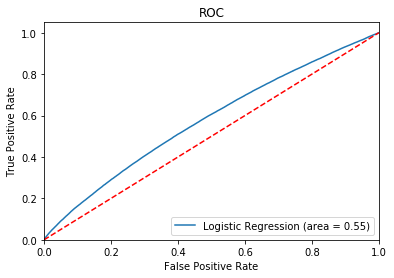

In [55]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logitRocAuc = roc_auc_score(y_test, lrMod.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, lrMod.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logitRocAuc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

In [56]:
print('Coefficient: \n', model.coef_)
print('Intercept: \n', model.intercept_)

NameError: name 'model' is not defined